In [133]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes
import bigframes.pandas as bpd
from IPython.display import display, HTML
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
from datetime import datetime
from typing import Union
import logging
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def extract_test_data(entity):
    
    query = f"""
        SELECT des.entity_id
            ,des.test_id
            ,des.test_start_date
            ,des.test_end_date
            ,des.variation_group
            ,des.variation_share
        FROM `fulfillment-dwh-production.cl.dps_experiment_setups` des
        WHERE des.test_start_date > '2024-01-01'
        AND date(des.test_end_date) < current_date()
        AND des.entity_id = '{entity}'  -- Ensure entity is properly injected
        AND test_start_date is not null
        --AND test_id > 5
        GROUP BY 1,2,3,4,5,6
        ORDER BY des.entity_id, des.test_start_date
    """
    
    return query


# def impact_estimation(entity, test_1, test_2):

#     query = f"""

#         WITH test_data AS (
#         SELECT
#             entity_id,
#             perseus_client_id,
#             CAST(test_id AS INT64) AS test_id,
#             LOWER(test_variant) AS test_variant
#         FROM `fulfillment-dwh-production.cl.dps_test_users`
#         WHERE entity_id = '{entity}'
#         AND test_id IN ({test_1}, {test_2})  -- Specific test IDs
#     ),

#     pivoted_data AS (
#         SELECT
#             entity_id,
#             perseus_client_id,
#             MAX(CASE WHEN test_id = {test_1} AND lower(test_variant) = "control" THEN 1 ELSE 0 END) AS is_control_A,
#             MAX(CASE WHEN test_id = {test_1} AND lower(test_variant) LIKE '%variation%' THEN 1 ELSE 0 END) AS is_variation_A,
#             MAX(CASE WHEN test_id = {test_2} AND lower(test_variant) = "control" THEN 1 ELSE 0 END) AS is_control_B,
#             MAX(CASE WHEN test_id = {test_2} AND lower(test_variant) LIKE '%variation%' THEN 1 ELSE 0 END) AS is_variation_B
#         FROM test_data
#         GROUP BY entity_id, perseus_client_id
#     ),

#     classified_users AS (
#         SELECT
#             entity_id,
#             perseus_client_id,
#             CASE
#                 WHEN is_control_A = 1 AND is_control_B = 1 THEN 'Control'
#                 WHEN is_variation_A = 1 AND is_control_B = 1 THEN 'A Only'
#                 WHEN is_control_A = 1 AND is_variation_B = 1 THEN 'B Only'
#                 WHEN is_variation_A = 1 AND is_variation_B = 1 THEN 'A+B'
#             END AS user_group
#         FROM pivoted_data
#         WHERE NOT (is_control_A = 1 AND is_variation_A = 1)  
#         AND NOT (is_control_B = 1 AND is_variation_B = 1)
#     ),

#     user_metrics AS (
#         SELECT 
#             m.perseus_client_id,
#             m.entity_id,
#             COUNT(DISTINCT m.order_id) AS total_orders,
#             SUM(m.fully_loaded_gross_profit_eur) AS flgp_eur
#         FROM `fulfillment-dwh-production.cl.dps_test_orders` m
#         WHERE entity_id = '{entity}'
#         AND test_id in ({test_1}, {test_2})  -- Orders only during the test period
#         GROUP BY m.perseus_client_id, m.entity_id
#     ),

#     order_metrics AS (
#         SELECT
#             cu.entity_id,
#             cu.user_group,
#             AVG(COALESCE(uo.total_orders, 0)) AS avg_orders_per_user,
#             AVG(COALESCE(uo.flgp_eur, 0)) AS avg_flgp_per_user,
#             SUM(COALESCE(uo.total_orders, 0)) AS total_orders,
#             SUM(COALESCE(uo.flgp_eur, 0)) AS total_flgp,
#             COUNT(DISTINCT cu.perseus_client_id) AS total_users
#         FROM classified_users cu
#         LEFT JOIN user_metrics uo  
#             ON cu.perseus_client_id = uo.perseus_client_id 
#             AND cu.entity_id = uo.entity_id
#         WHERE cu.user_group IS NOT NULL
#         GROUP BY cu.entity_id, cu.user_group
#     ),

#     did_calculations AS (
#         SELECT 
#             entity_id,

#             ROUND(
#                 COALESCE(MAX(CASE WHEN user_group = 'A+B' THEN avg_orders_per_user ELSE NULL END), 0) 
#             - COALESCE(MAX(CASE WHEN user_group = 'A Only' THEN avg_orders_per_user ELSE NULL END), 0)
#             - COALESCE(MAX(CASE WHEN user_group = 'B Only' THEN avg_orders_per_user ELSE NULL END), 0)
#             + COALESCE(MAX(CASE WHEN user_group = 'Control' THEN avg_orders_per_user ELSE NULL END), 0),
#             4) AS did_interaction_effect_orders,

#             ROUND(
#                 COALESCE(MAX(CASE WHEN user_group = 'A+B' THEN avg_flgp_per_user ELSE NULL END), 0) 
#             - COALESCE(MAX(CASE WHEN user_group = 'A Only' THEN avg_flgp_per_user ELSE NULL END), 0)
#             - COALESCE(MAX(CASE WHEN user_group = 'B Only' THEN avg_flgp_per_user ELSE NULL END), 0)
#             + COALESCE(MAX(CASE WHEN user_group = 'Control' THEN avg_flgp_per_user ELSE NULL END), 0),
#             4) AS did_interaction_effect_flgp,

#             COALESCE(MAX(CASE WHEN user_group = 'A+B' THEN total_users ELSE NULL END), 0) AS total_users_A_B
#         FROM order_metrics
#         GROUP BY entity_id
#     )

#     SELECT 
#         om.entity_id,
#         om.user_group,
#         om.avg_flgp_per_user,
#         om.avg_orders_per_user,
#         om.total_orders,
#         om.total_flgp,
#         om.total_users,
#         dc.did_interaction_effect_orders,

#         ROUND(dc.did_interaction_effect_orders * dc.total_users_A_B, 0) AS impact_on_total_orders,

#         dc.did_interaction_effect_flgp,

#         ROUND(dc.did_interaction_effect_flgp * dc.total_users_A_B, 2) AS impact_on_total_flgp

#     FROM order_metrics om
#     JOIN did_calculations dc 
#         ON om.entity_id = dc.entity_id
#     ORDER BY om.entity_id;

#     """

#     return query

# def impact_estimation(entity, test_1, test_2):

#     query = f"""

#         WITH test_data AS (
#         SELECT
#             entity_id,
#             (case when entity_id like '%GV%' then customer_id else perseus_client_id end) perseus_client_id,
#             CAST(test_id AS INT64) AS test_id,
#             LOWER(test_variant) AS test_variant
#         FROM `fulfillment-dwh-production.cl.dps_test_users`
#         WHERE entity_id = '{entity}'
#         AND test_id IN ({test_1}, {test_2})  -- Specific test IDs
#     ),

#     pivoted_data AS (
#         SELECT
#             entity_id,
#             perseus_client_id,
#             MAX(CASE WHEN test_id = {test_1} AND lower(test_variant) = "control" THEN 1 ELSE 0 END) AS is_control_A,
#             MAX(CASE WHEN test_id = {test_1} AND lower(test_variant) LIKE '%variation%' THEN 1 ELSE 0 END) AS is_variation_A,
#             MAX(CASE WHEN test_id = {test_2} AND lower(test_variant) = "control" THEN 1 ELSE 0 END) AS is_control_B,
#             MAX(CASE WHEN test_id = {test_2} AND lower(test_variant) LIKE '%variation%' THEN 1 ELSE 0 END) AS is_variation_B
#         FROM test_data
#         GROUP BY entity_id, perseus_client_id
#     ),

#     classified_users AS (
#         SELECT
#             entity_id,
#             perseus_client_id,
#             CASE
#                 WHEN is_control_A = 1 AND is_control_B = 1 THEN 'Control'
#                 WHEN is_variation_A = 1 AND is_control_B = 1 THEN 'A Only'
#                 WHEN is_control_A = 1 AND is_variation_B = 1 THEN 'B Only'
#                 WHEN is_variation_A = 1 AND is_variation_B = 1 THEN 'A+B'
#             END AS user_group
#         FROM pivoted_data
#         WHERE NOT (is_control_A = 1 AND is_variation_A = 1)  
#         AND NOT (is_control_B = 1 AND is_variation_B = 1)
#     ),

#     user_metrics AS (
#         SELECT 
#             (case when m.entity_id like '%GV%' then m.customer_id else m.perseus_client_id end) perseus_client_id,
#             m.entity_id,
#             COUNT(DISTINCT m.order_id) AS total_orders,
#             SUM(m.fully_loaded_gross_profit_eur) AS flgp_eur
#         FROM `fulfillment-dwh-production.cl.dps_test_orders` m
#         WHERE entity_id = '{entity}'
#         AND test_id in ({test_1}, {test_2})  -- Orders only during the test period
#         GROUP BY perseus_client_id, m.entity_id
#     ),

#     order_metrics AS (
#         SELECT
#             cu.entity_id,
#             cu.user_group,
#             AVG(COALESCE(uo.total_orders, 0)) AS avg_orders_per_user,
#             AVG(COALESCE(uo.flgp_eur, 0)) AS avg_flgp_per_user,
#             SUM(COALESCE(uo.total_orders, 0)) AS total_orders,
#             SUM(COALESCE(uo.flgp_eur, 0)) AS total_flgp,
#             COUNT(DISTINCT cu.perseus_client_id) AS total_users
#         FROM classified_users cu
#         LEFT JOIN user_metrics uo  
#             ON cu.perseus_client_id = uo.perseus_client_id 
#             AND cu.entity_id = uo.entity_id
#         WHERE cu.user_group IS NOT NULL
#         GROUP BY cu.entity_id, cu.user_group
#     ),

#     did_calculations AS (
#         SELECT 
#             entity_id,

#             ROUND(
#                 COALESCE(MAX(CASE WHEN user_group = 'A+B' THEN avg_orders_per_user ELSE NULL END), 0) 
#             - COALESCE(MAX(CASE WHEN user_group = 'A Only' THEN avg_orders_per_user ELSE NULL END), 0)
#             - COALESCE(MAX(CASE WHEN user_group = 'B Only' THEN avg_orders_per_user ELSE NULL END), 0)
#             + COALESCE(MAX(CASE WHEN user_group = 'Control' THEN avg_orders_per_user ELSE NULL END), 0),
#             4) AS did_interaction_effect_orders,

#             ROUND(
#                 COALESCE(MAX(CASE WHEN user_group = 'A+B' THEN avg_flgp_per_user ELSE NULL END), 0) 
#             - COALESCE(MAX(CASE WHEN user_group = 'A Only' THEN avg_flgp_per_user ELSE NULL END), 0)
#             - COALESCE(MAX(CASE WHEN user_group = 'B Only' THEN avg_flgp_per_user ELSE NULL END), 0)
#             + COALESCE(MAX(CASE WHEN user_group = 'Control' THEN avg_flgp_per_user ELSE NULL END), 0),
#             4) AS did_interaction_effect_flgp,

#             COALESCE(MAX(CASE WHEN user_group = 'A+B' THEN total_users ELSE NULL END), 0) AS total_users_A_B
#         FROM order_metrics
#         GROUP BY entity_id
#     )

#     SELECT 
#         om.entity_id,
#         om.user_group,
#         om.avg_flgp_per_user,
#         om.avg_orders_per_user,
#         om.total_orders,
#         om.total_flgp,
#         om.total_users,
#         dc.did_interaction_effect_orders,

#         ROUND(dc.did_interaction_effect_orders * dc.total_users_A_B, 0) AS impact_on_total_orders,

#         dc.did_interaction_effect_flgp,

#         ROUND(dc.did_interaction_effect_flgp * dc.total_users_A_B, 2) AS impact_on_total_flgp

#     FROM order_metrics om
#     JOIN did_calculations dc 
#         ON om.entity_id = dc.entity_id
#     ORDER BY om.entity_id;

#     """

#     return query


def impact_estimation(entity, test_1, test_2):

    query = f"""

            --------------------------------------------------------------------------------
        -- Step 1: Build up the data with subgroups, pivot them, compute naive/corrected
        --         differences for both A and B (Orders and FLGP), and store in 'final'
        --------------------------------------------------------------------------------
        WITH

        -- 1) Identify user assignments for test A (ID=68) and test B (ID=69)
        test_data AS (
            SELECT
                entity_id,
                perseus_client_id,
                CAST(test_id AS INT64) AS test_id,
                LOWER(test_variant) AS test_variant
            FROM `fulfillment-dwh-production.cl.dps_test_users`
            WHERE entity_id = '{entity}'
            AND test_id IN ({test_1}, {test_2})
        ),

        -- 2) Pivot each user's assignment to A=Control/Treatment, B=Control/Treatment
        pivoted_data AS (
            SELECT
                entity_id,
                perseus_client_id,
                MAX(CASE WHEN test_id = {test_1} AND test_variant = 'control' THEN 1 ELSE 0 END) AS is_A_control,
                MAX(CASE WHEN test_id = {test_1} AND test_variant LIKE '%variation%' THEN 1 ELSE 0 END) AS is_A_treatment,
                MAX(CASE WHEN test_id = {test_2} AND test_variant = 'control' THEN 1 ELSE 0 END) AS is_B_control,
                MAX(CASE WHEN test_id = {test_2} AND test_variant LIKE '%variation%' THEN 1 ELSE 0 END) AS is_B_treatment
            FROM test_data
            GROUP BY entity_id, perseus_client_id
        ),

        -- 3) Classify each user into exactly one of the 4 subgroups (Control, A Only, B Only, A+B)
        classified_users AS (
            SELECT
                entity_id,
                perseus_client_id,
                CASE
                    WHEN is_A_control = 1    AND is_B_control = 1    THEN 'Control'
                    WHEN is_A_treatment = 1  AND is_B_control = 1    THEN 'A Only'
                    WHEN is_A_control = 1    AND is_B_treatment = 1  THEN 'B Only'
                    WHEN is_A_treatment = 1  AND is_B_treatment = 1  THEN 'A+B'
                    ELSE NULL
                END AS subgroup
            FROM pivoted_data
            WHERE NOT (is_A_control = 1 AND is_A_treatment = 1)  
            AND NOT (is_B_control = 1 AND is_B_treatment = 1)
        ),

        -- 4) Get user-level Orders & FLGP
        user_metrics AS (
            SELECT
                perseus_client_id,
                entity_id,
                COUNT(DISTINCT order_id) AS total_orders,
                SUM(fully_loaded_gross_profit_eur) AS total_flgp
            FROM `fulfillment-dwh-production.cl.dps_test_orders`
            WHERE entity_id = '{entity}'
            AND test_id IN ({test_1}, {test_2})
            GROUP BY perseus_client_id, entity_id
        ),

        -- 5) Summaries for each subgroup: total users, total orders, total flgp, average orders/flgp
        subgroup_metrics AS (
            SELECT
                cu.entity_id,
                cu.subgroup,
                COUNT(DISTINCT cu.perseus_client_id)             AS subgroup_user_count,
                SUM(COALESCE(um.total_orders, 0))                AS subgroup_total_orders,
                SUM(COALESCE(um.total_flgp, 0))                  AS subgroup_total_flgp,
                AVG(COALESCE(um.total_orders, 0))                AS subgroup_avg_orders_per_user,
                AVG(COALESCE(um.total_flgp, 0))                  AS subgroup_avg_flgp_per_user
            FROM classified_users cu
            LEFT JOIN user_metrics um
                ON cu.perseus_client_id = um.perseus_client_id
            AND cu.entity_id = um.entity_id
            WHERE cu.subgroup IS NOT NULL
            GROUP BY cu.entity_id, cu.subgroup
        ),

        -- 6) Pivot subgroups into columns
        pivoted_subgroups AS (
            SELECT
                entity_id,

                COALESCE(MAX(CASE WHEN subgroup = 'Control' THEN subgroup_user_count END),0) AS control_user_count,
                COALESCE(MAX(CASE WHEN subgroup = 'A Only'  THEN subgroup_user_count END),0) AS a_only_user_count,
                COALESCE(MAX(CASE WHEN subgroup = 'B Only'  THEN subgroup_user_count END),0) AS b_only_user_count,
                COALESCE(MAX(CASE WHEN subgroup = 'A+B'     THEN subgroup_user_count END),0) AS a_b_user_count,

                COALESCE(MAX(CASE WHEN subgroup = 'Control' THEN subgroup_avg_orders_per_user END),0) AS control_avg_orders,
                COALESCE(MAX(CASE WHEN subgroup = 'A Only'  THEN subgroup_avg_orders_per_user END),0) AS a_only_avg_orders,
                COALESCE(MAX(CASE WHEN subgroup = 'B Only'  THEN subgroup_avg_orders_per_user END),0) AS b_only_avg_orders,
                COALESCE(MAX(CASE WHEN subgroup = 'A+B'     THEN subgroup_avg_orders_per_user END),0) AS a_b_avg_orders,

                COALESCE(MAX(CASE WHEN subgroup = 'Control' THEN subgroup_avg_flgp_per_user END),0) AS control_avg_flgp,
                COALESCE(MAX(CASE WHEN subgroup = 'A Only'  THEN subgroup_avg_flgp_per_user END),0) AS a_only_avg_flgp,
                COALESCE(MAX(CASE WHEN subgroup = 'B Only'  THEN subgroup_avg_flgp_per_user END),0) AS b_only_avg_flgp,
                COALESCE(MAX(CASE WHEN subgroup = 'A+B'     THEN subgroup_avg_flgp_per_user END),0) AS a_b_avg_flgp
            FROM subgroup_metrics
            GROUP BY entity_id
        ),

        -- 7) 'final' CTE: define all naive/corrected/bias columns for A and B, Orders & FLGP
        final AS (
            SELECT
                ps.entity_id,

                -- Bring in the subgroup counts:
                ps.control_user_count,
                ps.a_only_user_count,
                ps.b_only_user_count,
                ps.a_b_user_count,

                -- The average metrics for each subgroup:
                ps.control_avg_orders,
                ps.a_only_avg_orders,
                ps.b_only_avg_orders,
                ps.a_b_avg_orders,

                ps.control_avg_flgp,
                ps.a_only_avg_flgp,
                ps.b_only_avg_flgp,
                ps.a_b_avg_flgp,

                -- Summaries for "A=Treatment" vs "A=Control"
                (ps.a_b_user_count + ps.a_only_user_count) AS a_treatment_user_count,
                (ps.b_only_user_count + ps.control_user_count) AS a_control_user_count,

                -- Summaries for "B=Treatment" vs "B=Control"
                (ps.a_b_user_count + ps.b_only_user_count) AS b_treatment_user_count,
                (ps.a_only_user_count + ps.control_user_count) AS b_control_user_count,

                -- Total users
                (ps.a_b_user_count + ps.a_only_user_count + ps.b_only_user_count + ps.control_user_count) AS total_users,

                -- =====================================================
                -- PART A: ORDERS
                -- =====================================================

                -- ========== naive_A_diff_orders ==========
                CASE
                WHEN (ps.a_b_user_count + ps.a_only_user_count) = 0
                    OR (ps.b_only_user_count + ps.control_user_count) = 0
                THEN 0
                ELSE
                    (
                    (ps.a_b_avg_orders * ps.a_b_user_count
                    + ps.a_only_avg_orders * ps.a_only_user_count)
                    / NULLIF((ps.a_b_user_count + ps.a_only_user_count), 0)
                    )
                    -
                    (
                    (ps.b_only_avg_orders * ps.b_only_user_count
                    + ps.control_avg_orders * ps.control_user_count)
                    / NULLIF((ps.b_only_user_count + ps.control_user_count), 0)
                    )
                END AS naive_a_diff_orders,

                -- ========== corrected_A_diff_orders ==========
                CASE
                WHEN (ps.a_b_user_count + ps.a_only_user_count + ps.b_only_user_count + ps.control_user_count) = 0
                THEN 0
                ELSE
                    (
                    ((ps.a_b_user_count + ps.b_only_user_count)*1.0 
                        / NULLIF((ps.a_b_user_count + ps.a_only_user_count + ps.b_only_user_count + ps.control_user_count),0))
                    * (ps.a_b_avg_orders - ps.b_only_avg_orders)
                    )
                    +
                    (
                    ((ps.a_only_user_count + ps.control_user_count)*1.0
                        / NULLIF((ps.a_b_user_count + ps.a_only_user_count + ps.b_only_user_count + ps.control_user_count),0))
                    * (ps.a_only_avg_orders - ps.control_avg_orders)
                    )
                END AS corrected_a_diff_orders,

                -- ========== naive_B_diff_orders ==========
                CASE
                WHEN (ps.a_b_user_count + ps.b_only_user_count) = 0
                    OR (ps.a_only_user_count + ps.control_user_count) = 0
                THEN 0
                ELSE
                    (
                    (ps.a_b_avg_orders * ps.a_b_user_count
                    + ps.b_only_avg_orders * ps.b_only_user_count)
                    / NULLIF((ps.a_b_user_count + ps.b_only_user_count), 0)
                    )
                    -
                    (
                    (ps.a_only_avg_orders * ps.a_only_user_count
                    + ps.control_avg_orders * ps.control_user_count)
                    / NULLIF((ps.a_only_user_count + ps.control_user_count), 0)
                    )
                END AS naive_b_diff_orders,

                -- ========== corrected_B_diff_orders ==========
                CASE
                WHEN (ps.a_b_user_count + ps.a_only_user_count + ps.b_only_user_count + ps.control_user_count) = 0
                THEN 0
                ELSE
                    (
                    ((ps.a_b_user_count + ps.a_only_user_count)*1.0
                        / NULLIF((ps.a_b_user_count + ps.a_only_user_count + ps.b_only_user_count + ps.control_user_count),0))
                    * (ps.a_b_avg_orders - ps.a_only_avg_orders)
                    )
                    +
                    (
                    ((ps.b_only_user_count + ps.control_user_count)*1.0
                        / NULLIF((ps.a_b_user_count + ps.a_only_user_count + ps.b_only_user_count + ps.control_user_count),0))
                    * (ps.b_only_avg_orders - ps.control_avg_orders)
                    )
                END AS corrected_b_diff_orders,

                -- =====================================================
                -- PART A: FLGP
                -- =====================================================

                -- ========== naive_A_diff_flgp ==========
                CASE
                WHEN (ps.a_b_user_count + ps.a_only_user_count) = 0
                    OR (ps.b_only_user_count + ps.control_user_count) = 0
                THEN 0
                ELSE
                    (
                    (ps.a_b_avg_flgp * ps.a_b_user_count
                    + ps.a_only_avg_flgp * ps.a_only_user_count)
                    / NULLIF((ps.a_b_user_count + ps.a_only_user_count), 0)
                    )
                    -
                    (
                    (ps.b_only_avg_flgp * ps.b_only_user_count
                    + ps.control_avg_flgp * ps.control_user_count)
                    / NULLIF((ps.b_only_user_count + ps.control_user_count), 0)
                    )
                END AS naive_a_diff_flgp,

                -- ========== corrected_A_diff_flgp ==========
                CASE
                WHEN (ps.a_b_user_count + ps.a_only_user_count + ps.b_only_user_count + ps.control_user_count) = 0
                THEN 0
                ELSE
                    (
                    ((ps.a_b_user_count + ps.b_only_user_count)*1.0 
                        / NULLIF((ps.a_b_user_count + ps.a_only_user_count + ps.b_only_user_count + ps.control_user_count),0))
                    * (ps.a_b_avg_flgp - ps.b_only_avg_flgp)
                    )
                    +
                    (
                    ((ps.a_only_user_count + ps.control_user_count)*1.0
                        / NULLIF((ps.a_b_user_count + ps.a_only_user_count + ps.b_only_user_count + ps.control_user_count),0))
                    * (ps.a_only_avg_flgp - ps.control_avg_flgp)
                    )
                END AS corrected_a_diff_flgp,

                -- ========== naive_B_diff_flgp ==========
                CASE
                WHEN (ps.a_b_user_count + ps.b_only_user_count) = 0
                    OR (ps.a_only_user_count + ps.control_user_count) = 0
                THEN 0
                ELSE
                    (
                    (ps.a_b_avg_flgp * ps.a_b_user_count
                    + ps.b_only_avg_flgp * ps.b_only_user_count)
                    / NULLIF((ps.a_b_user_count + ps.b_only_user_count), 0)
                    )
                    -
                    (
                    (ps.a_only_avg_flgp * ps.a_only_user_count
                    + ps.control_avg_flgp * ps.control_user_count)
                    / NULLIF((ps.a_only_user_count + ps.control_user_count), 0)
                    )
                END AS naive_b_diff_flgp,

                -- ========== corrected_B_diff_flgp ==========
                CASE
                WHEN (ps.a_b_user_count + ps.a_only_user_count + ps.b_only_user_count + ps.control_user_count) = 0
                THEN 0
                ELSE
                    (
                    ((ps.a_b_user_count + ps.a_only_user_count)*1.0
                        / NULLIF((ps.a_b_user_count + ps.a_only_user_count + ps.b_only_user_count + ps.control_user_count),0))
                    * (ps.a_b_avg_flgp - ps.a_only_avg_flgp)
                    )
                    +
                    (
                    ((ps.b_only_user_count + ps.control_user_count)*1.0
                        / NULLIF((ps.a_b_user_count + ps.a_only_user_count + ps.b_only_user_count + ps.control_user_count),0))
                    * (ps.b_only_avg_flgp - ps.control_avg_flgp)
                    )
                END AS corrected_b_diff_flgp

                -- If you also want the "bias_for_a_orders" or "bias_for_b_orders" directly in SQL,
                -- you can do "naive - corrected" here. Or you can do that in Python afterward. 
                -- Similarly for the "impact_on_total_*" calculations.

            FROM pivoted_subgroups ps
        )

        --------------------------------------------------------------------------------
        -- Step 2: Filter out any entity_id that doesn't have all 4 subgroups
        --------------------------------------------------------------------------------
        SELECT
        *
        FROM final
        WHERE a_only_user_count    > 0
        AND b_only_user_count    > 0
        AND control_user_count   > 0
        AND a_b_user_count       > 0
        ORDER BY entity_id;



    """

    return query



def get_all_pairs():

    query = """
    
    WITH test_data AS (
        SELECT DISTINCT
        u.entity_id,
        CASE
        WHEN LEFT(SPLIT(CAST(u.test_id AS STRING), '_')[SAFE_OFFSET(0)], 2) = 'GV'
        THEN customer_id
        ELSE u.perseus_client_id
        END AS customer_id,
        CAST(u.test_id AS INT64) AS test_id,
        LOWER(u.test_variant) AS test_variant
        FROM `fulfillment-dwh-production.cl.dps_test_users` u
        JOIN `fulfillment-dwh-production.cl.dps_experiment_setups` e
        ON u.entity_id = e.entity_id
        AND u.test_id = e.test_id
        WHERE DATE(e.test_start_date) >= "2024-01-01"
        AND e.experiment_type = "AB"
        ),

        test_pairs AS (
        SELECT
        t1.entity_id,
        t1.test_id AS test_id_1,
        t2.test_id AS test_id_2
        FROM (SELECT DISTINCT entity_id, test_id FROM test_data) t1
        JOIN (SELECT DISTINCT entity_id, test_id FROM test_data) t2
        ON t1.entity_id = t2.entity_id
        AND t1.test_id < t2.test_id
        ),

        pivoted_data AS (
        SELECT
        entity_id,
        customer_id,
        test_id,
        COUNT(DISTINCT CASE WHEN test_variant = "control" THEN customer_id END) AS is_control,
        COUNT(DISTINCT CASE WHEN test_variant LIKE '%variation%' THEN customer_id END) AS is_variation
        FROM test_data
        GROUP BY entity_id, customer_id, test_id
        ),

        filtered_users AS (
        SELECT entity_id, customer_id, test_id
        FROM pivoted_data
        WHERE (is_control = 1 OR is_variation = 1)
        AND NOT (is_control = 1 AND is_variation = 1)
        ),

        user_variants AS (
        SELECT
        f.entity_id,
        f.customer_id,
        f.test_id,
        CASE
        WHEN p.is_control = 1 THEN "Control"
        WHEN p.is_variation = 1 THEN "Variation"
        END AS assigned_variant
        FROM filtered_users f
        JOIN pivoted_data p
        ON f.customer_id = p.customer_id
        AND f.test_id = p.test_id
        AND f.entity_id = p.entity_id
        ),

        filtered_test_pairs AS (
        SELECT
        u1.entity_id,
        u1.customer_id,
        tp.test_id_1,
        tp.test_id_2,
        u1.assigned_variant AS variant_1,
        u2.assigned_variant AS variant_2
        FROM test_pairs tp
        JOIN user_variants u1
        ON u1.entity_id = tp.entity_id
        AND u1.test_id = tp.test_id_1
        JOIN user_variants u2
        ON u2.entity_id = tp.entity_id
        AND u2.test_id = tp.test_id_2
        AND u1.customer_id = u2.customer_id
        ),

        overlap_analysis AS (
        SELECT
        entity_id,
        test_id_1,
        test_id_2,
        COUNT(DISTINCT customer_id) AS total_users_in_both,
        SUM(CASE WHEN variant_1 = "Control" AND variant_2 = "Control" THEN 1 ELSE 0 END) AS same_control,
        SUM(CASE WHEN variant_1 = "Variation" AND variant_2 = "Variation" THEN 1 ELSE 0 END) AS same_variation,
        SUM(CASE WHEN variant_1 = variant_2 THEN 1 ELSE 0 END) AS same_variant_both_tests
        FROM filtered_test_pairs
        GROUP BY entity_id, test_id_1, test_id_2
        )

        SELECT
        entity_id,
        test_id_1,
        test_id_2,
        total_users_in_both,
        same_control,
        same_variation,
        same_variant_both_tests,
        ROUND(same_variant_both_tests / NULLIF(total_users_in_both, 0), 2) AS overlap_ratio,
        ROUND(same_control / NULLIF(total_users_in_both, 0), 2) AS control_overlap_ratio,
        ROUND(same_variation / NULLIF(total_users_in_both, 0), 2) AS variation_overlap_ratio
        FROM overlap_analysis
        WHERE total_users_in_both > 1000
        ORDER BY entity_id, test_id_1, test_id_2;
     
    """

    return query



project_id = "logistics-customer-staging"
logging.info(f"Initializing BigQuery client for project: {project_id}")

try:
    # Initialize BigQuery client
    client = bigquery.Client(project=project_id)
except Exception as e:
    logging.error(f"Failed to initialize BigQuery client: {e}")
    sys.exit(1)

#entity_id = 'EF_GR'

#data_test = client.query(extract_test_data(entity_id)).to_dataframe()

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [134]:
#tests_df = client.query(get_all_pairs()).to_dataframe()
#impact_df = client.query(impact_estimation('EF_GR',68,69)).to_dataframe()
#test_df = pd.read_csv('/Users/shazeb.asad/Downloads/pairwise_tests.csv')

In [135]:
# # List of entity codes
# entity_codes = [
#     "AP_PA", "DJ_CZ", "EF_GR", "FO_NO", "FP_BD", "FP_HK", "FP_KH", "FP_LA", "FP_MM", "FP_MY", 
#     "FP_PH", "FP_PK", "FP_SG", "FP_TH", "FP_TW", "FY_CY", "GV_BA", "GV_BG", "GV_HR", "GV_KE", 
#     "GV_MA", "GV_MD", "GV_ME", "GV_NG", "GV_PT", "GV_RO", "GV_RS", "GV_TN", "HF_EG", "HS_SA", 
#     "MJM_AT", "NP_HU", "OP_SE", "PO_FI", "PY_AR", "PY_BO", "PY_CL", "PY_CR", "PY_DO", "PY_EC", 
#     "PY_GT", "PY_HN", "PY_NI", "PY_PE", "PY_PY", "PY_SV", "PY_UY", "PY_VE", "TB_AE", "TB_BH", 
#     "TB_IQ", "TB_JO", "TB_KW", "TB_OM", "TB_QA", "YS_TR"
# ]

# # Convert to a comma-separated tuple with quotation marks
# entity_tuple = ( + ", ".join(f"'{entity}'" for entity in entity_codes) + )

# # Display the result
# entity_tuple


In [136]:
# impact_bias = test_df[
#     (test_df['entity_id'].isin([
#         "AP_PA", "DJ_CZ", "EF_GR", "FO_NO", "FP_BD", "FP_HK", "FP_KH", "FP_LA", "FP_MM", "FP_MY", 
#         "FP_PH", "FP_PK", "FP_SG", "FP_TH", "FP_TW", "FY_CY", "GV_BA", "GV_BG", "GV_HR", "GV_KE", 
#         "GV_MA", "GV_MD", "GV_ME", "GV_NG", "GV_PT", "GV_RO", "GV_RS", "GV_TN", "HF_EG", "HS_SA", 
#         "MJM_AT", "NP_HU", "OP_SE", "PO_FI", "PY_AR", "PY_BO", "PY_CL", "PY_CR", "PY_DO", "PY_EC", 
#         "PY_GT", "PY_HN", "PY_NI", "PY_PE", "PY_PY", "PY_SV", "PY_UY", "PY_VE", "TB_AE", "TB_BH", 
#         "TB_IQ", "TB_JO", "TB_KW", "TB_OM", "TB_QA", "YS_TR"
#     ])) & 
#     (test_df['overlap_ratio'] > 0.5)
# ]

impact_bias = test_df[
    (test_df['entity_id'] == 
        "AP_PA") & 
    (test_df['overlap_ratio'] > 0.5)
]

if 'test_id_1' in impact_bias.columns and 'test_id_2' in impact_bias.columns:
    entity_list = impact_bias['entity_id'].unique().tolist()
    test_pairs = impact_bias[['test_id_1', 'test_id_2']].drop_duplicates().apply(tuple, axis=1).tolist()
else:
    entity_list = []
    test_pairs = []

entity_list, test_pairs

results_df = pd.DataFrame()

# Loop through each entity and test pair, execute query, and append results
for entity in entity_list:
    for test_1, test_2 in test_pairs:
        query_result = client.query(impact_estimation(entity, test_1, test_2)).to_dataframe()

        # Add test_id_1 and test_id_2 columns to keep track of test pairs
        query_result["test_id_1"] = test_1
        query_result["test_id_2"] = test_2

        # Append to the results DataFrame
        results_df = pd.concat([results_df, query_result], ignore_index=True)

# results_agg_df = results_df.groupby(['entity_id','test_id_1', 'test_id_2']).agg({
#     'impact_on_total_orders': 'max',
#     'impact_on_total_flgp': 'max'
# }).reset_index()



/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_63332/3731001440.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, query_result], ignore_index=True)
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_63332/3731001440.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, query_result], ignore_index=True)
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_63332/3731001440.py:40: FutureWarning: The 

In [131]:
results_df.columns

Index(['entity_id', 'control_user_count', 'a_only_user_count',
       'b_only_user_count', 'a_b_user_count', 'control_avg_orders',
       'a_only_avg_orders', 'b_only_avg_orders', 'a_b_avg_orders',
       'control_avg_flgp', 'a_only_avg_flgp', 'b_only_avg_flgp',
       'a_b_avg_flgp', 'a_treatment_user_count', 'a_control_user_count',
       'b_treatment_user_count', 'b_control_user_count', 'total_users',
       'naive_a_diff_orders', 'corrected_a_diff_orders', 'test_id_1',
       'test_id_2'],
      dtype='object')

In [147]:
df = results_df.copy()

# 2. Create new columns for the per-user bias:
df["bias_for_a_orders"] = df["naive_a_diff_orders"] - df["corrected_a_diff_orders"]
df["bias_for_b_orders"] = df["naive_b_diff_orders"] - df["corrected_b_diff_orders"]

df["bias_for_a_flgp"] = df["naive_a_diff_flgp"] - df["corrected_a_diff_flgp"]
df["bias_for_b_flgp"] = df["naive_b_diff_flgp"] - df["corrected_b_diff_flgp"]

# 3. Multiply each per-user bias by the # of treatment users to get total bias:
df["total_bias_orders_for_a"] = df["bias_for_a_orders"] * df["a_treatment_user_count"]
df["total_bias_orders_for_b"] = df["bias_for_b_orders"] * df["b_treatment_user_count"]

df["total_bias_flgp_for_a"] = df["bias_for_a_flgp"] * df["a_treatment_user_count"]
df["total_bias_flgp_for_b"] = df["bias_for_b_flgp"] * df["b_treatment_user_count"]

# 4. Now df contains the columns showing how many total orders/FLGP are over- (or under-) counted
#    for each test if you ignore the overlap.
print(df[[
    "entity_id", "bias_for_a_orders", "bias_for_b_orders",
    "bias_for_a_flgp", "bias_for_b_flgp",
    "total_bias_orders_for_a", "total_bias_orders_for_b",
    "total_bias_flgp_for_a", "total_bias_flgp_for_b"
]])

    entity_id  bias_for_a_orders  bias_for_b_orders  bias_for_a_flgp  \
0       AP_PA           0.001467           0.000211         0.017086   
1       AP_PA          -0.003729           0.000119         0.020705   
2       AP_PA           0.068469           0.132527         0.080346   
3       AP_PA          -0.010937           0.020760        -0.027477   
4       AP_PA          -0.000762          -0.000697        -0.000933   
..        ...                ...                ...              ...   
103     AP_PA          -0.000034           0.000023         0.000027   
104     AP_PA          -0.001534           0.001892        -0.011913   
105     AP_PA           0.000092           0.000436        -0.000487   
106     AP_PA          -0.029195           0.008969         0.017007   
107     AP_PA          -0.000148          -0.000718        -0.000720   

     bias_for_b_flgp  total_bias_orders_for_a  total_bias_orders_for_b  \
0          -0.007999                 4.262556                

In [150]:
df['total_bias_flgp_for_a'].sum()

-73742.69556115805

In [149]:
df['total_bias_flgp_for_a'].mean()

-682.8027366773894

In [145]:
results_df['total_bias_flgp_for_a'].mean() + results_df['total_bias_flgp_for_b'].mean()

KeyError: 'total_bias_flgp_for_a'

In [101]:
final_impact_df = results_agg_df.groupby('entity_id').agg({"impact_on_total_orders":'sum','impact_on_total_flgp':'sum'}).reset_index()

final_impact_df

,entity_id,impact_on_total_orders,impact_on_total_flgp
0,AP_PA,3423937.0,5650090.05


In [106]:
a = client.query(impact_estimation('AP_PA', 104, 109)).to_dataframe()

In [107]:
a

,entity_id,user_group,avg_flgp_per_user,avg_orders_per_user,total_orders,total_flgp,total_users,did_interaction_effect_orders,impact_on_total_orders,did_interaction_effect_flgp,impact_on_total_flgp
0,AP_PA,Control,11.520163,8.931911,17578,22671.679817,1968,9.3016,62442.0,12.0466,80868.83
1,AP_PA,A Only,10.795562,8.411498,11120,14271.733274,1322,9.3016,62442.0,12.0466,80868.83
2,AP_PA,A+B,11.321974,8.781171,58948,76004.410094,6713,9.3016,62442.0,12.0466,80868.83


In [152]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# Example: Simulated user-level data for multiple experiments
np.random.seed(42)
num_users = 10000

df = pd.DataFrame({
    'user_id': np.arange(num_users),
    'experiment_1_orders': np.random.randint(0, 5, num_users),  # Number of orders
    'experiment_2_orders': np.random.randint(0, 5, num_users),
    'experiment_1_flgp': np.random.rand(num_users),  # FLGP metric (0-1)
    'experiment_2_flgp': np.random.rand(num_users),
    'overlap': np.random.choice([0,1], size=num_users, p=[0.8, 0.2])  # 20% overlap
})

# Compute correlation between experiments for each metric
correlation_orders = df[['experiment_1_orders', 'experiment_2_orders']].corr().iloc[0,1]
correlation_flgp = df[['experiment_1_flgp', 'experiment_2_flgp']].corr().iloc[0,1]

print(f"Correlation Between Experiments - Orders: {correlation_orders:.4f}")
print(f"Correlation Between Experiments - FLGP: {correlation_flgp:.4f}")

# Assume estimated true treatment effect from independent experiments
tau_orders_true = 0.05  # Example: A known effect size for orders
tau_flgp_true = 0.02  # Example: A known effect size for FLGP
N = 2  # Number of experiments overlapping

# Compute bias approximation
bias_orders = (N-1) * correlation_orders * tau_orders_true
bias_flgp = (N-1) * correlation_flgp * tau_flgp_true

print(f"Bias Estimate - Orders: {bias_orders:.4f}")
print(f"Bias Estimate - FLGP: {bias_flgp:.4f}")

# --- Empirical Bias Estimation ---

# Compute observed treatment effects for overlapping vs. independent users
tau_orders_overlap = df[df['overlap'] == 1]['experiment_1_orders'].mean()
tau_orders_independent = df[df['overlap'] == 0]['experiment_1_orders'].mean()
empirical_bias_orders = tau_orders_overlap - tau_orders_independent

tau_flgp_overlap = df[df['overlap'] == 1]['experiment_1_flgp'].mean()
tau_flgp_independent = df[df['overlap'] == 0]['experiment_1_flgp'].mean()
empirical_bias_flgp = tau_flgp_overlap - tau_flgp_independent

print(f"Empirical Bias Estimate - Orders: {empirical_bias_orders:.4f}")
print(f"Empirical Bias Estimate - FLGP: {empirical_bias_flgp:.4f}")

# Statistical significance test
t_stat_orders, p_value_orders = ttest_ind(df[df['overlap'] == 1]['experiment_1_orders'], 
                                          df[df['overlap'] == 0]['experiment_1_orders'])
t_stat_flgp, p_value_flgp = ttest_ind(df[df['overlap'] == 1]['experiment_1_flgp'], 
                                      df[df['overlap'] == 0]['experiment_1_flgp'])

print(f"T-test p-value - Orders: {p_value_orders:.4f}")
print(f"T-test p-value - FLGP: {p_value_flgp:.4f}")

if p_value_orders < 0.05:
    print("Bias in orders is statistically significant!")
else:
    print("No strong statistical evidence of bias in orders.")

if p_value_flgp < 0.05:
    print("Bias in FLGP is statistically significant!")
else:
    print("No strong statistical evidence of bias in FLGP.")


Correlation Between Experiments - Orders: -0.0069
Correlation Between Experiments - FLGP: -0.0133
Bias Estimate - Orders: -0.0003
Bias Estimate - FLGP: -0.0003
Empirical Bias Estimate - Orders: -0.0460
Empirical Bias Estimate - FLGP: -0.0108
T-test p-value - Orders: 0.1959
T-test p-value - FLGP: 0.1325
No strong statistical evidence of bias in orders.
No strong statistical evidence of bias in FLGP.


In [72]:
# # Convert to sets to remove duplicate pairs (unordered pairs)
# unique_pairs = set(tuple(sorted(pair)) for pair in zip(results_agg_df['test_id_1'], results_agg_df['test_id_2']))

# # Count the number of unique pairs
# num_unique_pairs = len(unique_pairs)

# # Display the result
# num_unique_pairs

5

In [109]:
0.0022579948402952077 * 3000

6.773984520885623

In [110]:
0.26610842772067128 * 3569

949.7409785350758

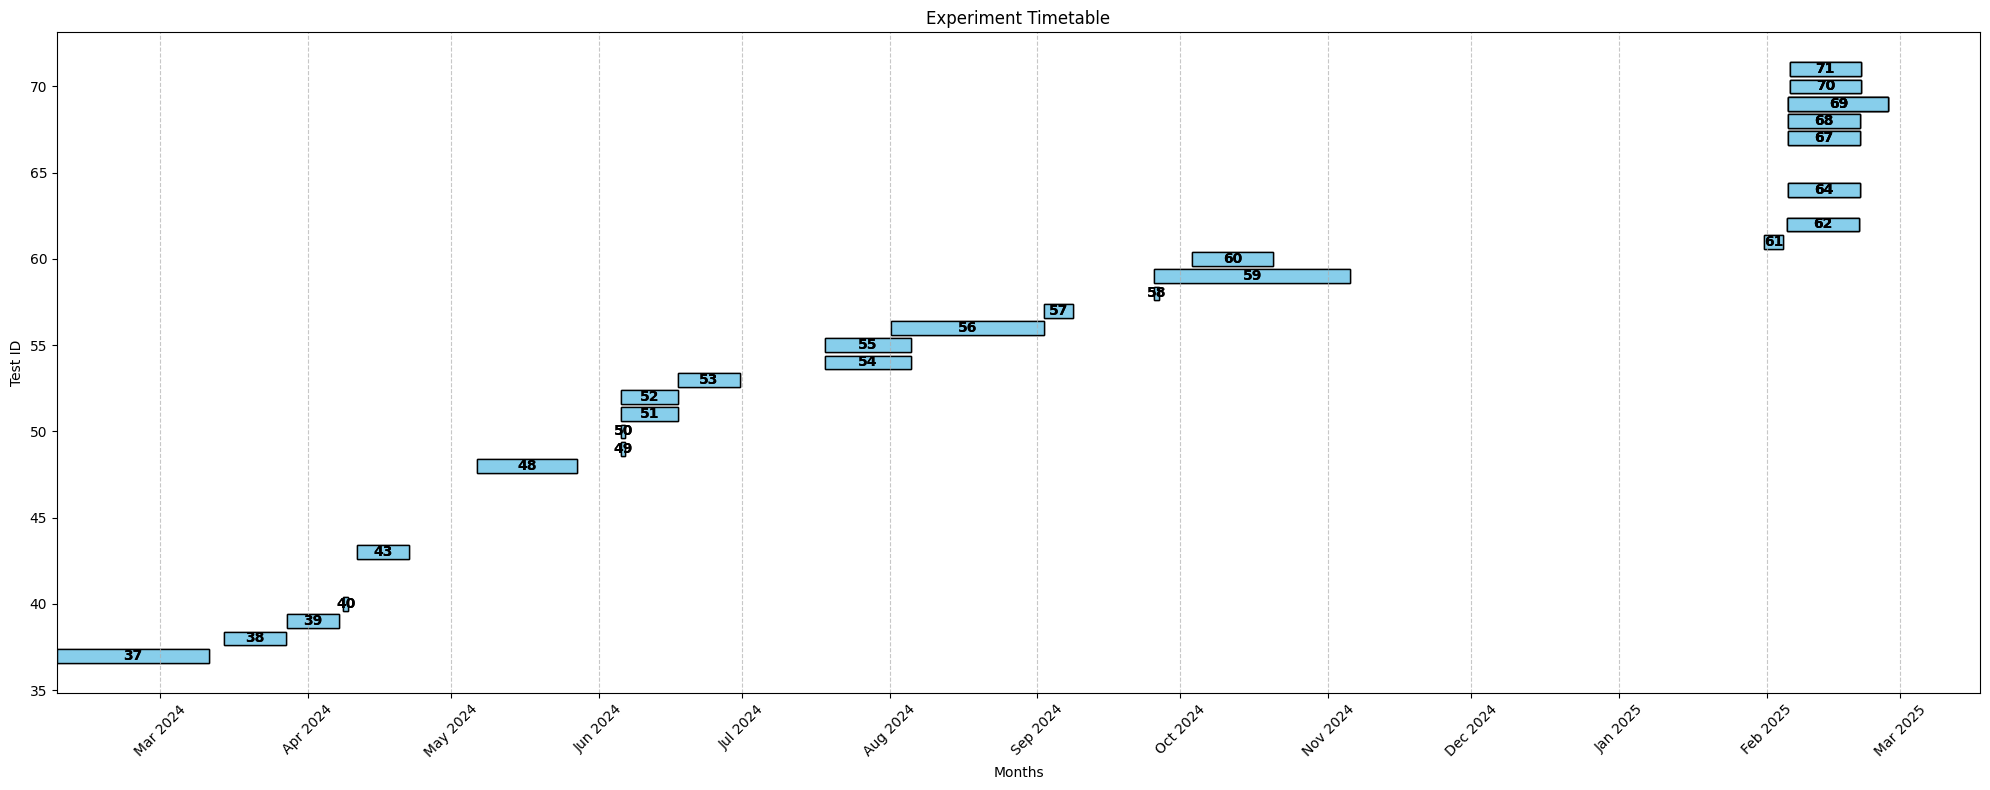

In [21]:
# Ensure 'test_start_date' and 'test_end_date' are properly converted to datetime
data_test["test_start_date"] = pd.to_datetime(data_test["test_start_date"], errors="coerce")
data_test["test_end_date"] = pd.to_datetime(data_test["test_end_date"], errors="coerce")

# Recalculate duration after filling missing values
data_test["duration"] = (data_test["test_end_date"] - data_test["test_start_date"]).dt.days

# Sort by start date for better visualization
data_test = data_test.sort_values(by="test_start_date")

fig, ax = plt.subplots(figsize=(20, 8))  # Width = 12, Height = 8

# Create a horizontal bar for each test
for i, row in data_test.iterrows():
    start_date = row["test_start_date"]
    duration = row["duration"]
    test_id = row["test_id"]

    # Ensure a minimum bar length for visibility
    min_duration = max(duration, 1)  

    # Plot the horizontal bar
    ax.barh(test_id, min_duration, left=start_date, color="skyblue", edgecolor="black")

    # Add Test ID label inside the bar
    ax.text(start_date + pd.Timedelta(days=min_duration / 2), test_id, str(test_id),
            va='center', ha='center', fontsize=10, color="black", fontweight='bold')

# Format X-axis as months
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45)

# Labels and title
ax.set_xlabel("Months")
ax.set_ylabel("Test ID")
ax.set_title("Experiment Timetable")

plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()  # Adjust layout to fit all bars properly
plt.show()
